# Introduction
- fc feature を作って保存する
- type ごとの学習を行って精度のいいfcを作成する　
- nb22 のangle feature も入れる
- nb28 のチューニングしたハイパーパラメータを使用した
- 5-fold

# Import everything I need :)

In [1]:
import time
import glob
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb
import multiprocessing
# from fastprogress import progress_bar

/usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


# Preparation

In [2]:
nb = 29
isSmallSet = False
length = 20000

In [3]:
pd.set_option('display.max_columns', 100)

In [4]:
file_path = '../input/champs-scalar-coupling/'
glob.glob(file_path + '*')

['../input/champs-scalar-coupling/scalar_coupling_contributions.csv',
 '../input/champs-scalar-coupling/magnetic_shielding_tensors.csv',
 '../input/champs-scalar-coupling/structures.csv',
 '../input/champs-scalar-coupling/test.csv',
 '../input/champs-scalar-coupling/dipole_moments.csv',
 '../input/champs-scalar-coupling/potential_energy.csv',
 '../input/champs-scalar-coupling/sample_submission.csv',
 '../input/champs-scalar-coupling/train.csv',
 '../input/champs-scalar-coupling/mulliken_charges.csv']

In [5]:
# train
path = file_path + 'train.csv'
if isSmallSet:
    train = pd.read_csv(path) [:length]
else:
    train = pd.read_csv(path)

In [6]:
# test
path = file_path + 'test.csv'
if isSmallSet:
    test = pd.read_csv(path)[:length]
else:
    test = pd.read_csv(path)

In [7]:
# structure
path = file_path + 'structures.csv'
structures = pd.read_csv(path)

In [8]:
# scalar coupling contributions
path = file_path + 'scalar_coupling_contributions.csv'
if isSmallSet:
    contrib = pd.read_csv(path)[:length]
else:
    contrib = pd.read_csv(path)

In [9]:
if isSmallSet:
    print('using SmallSet !!')
    print('-------------------')

print(f'There are {train.shape[0]} rows in train data.')
print(f'There are {test.shape[0]} rows in test data.')

print(f"There are {train['molecule_name'].nunique()} distinct molecules in train data.")
print(f"There are {test['molecule_name'].nunique()} distinct molecules in test data.")
print(f"There are {train['atom_index_0'].nunique()} unique atoms.")
print(f"There are {train['type'].nunique()} unique types.")

There are 4658147 rows in train data.
There are 2505542 rows in test data.
There are 85003 distinct molecules in train data.
There are 45772 distinct molecules in test data.
There are 29 unique atoms.
There are 8 unique types.


---
**metrics**

In [10]:
def kaggle_metric(df, preds):
    df["prediction"] = preds
    maes = []
    for t in df.type.unique():
        y_true = df[df.type==t].scalar_coupling_constant.values
        y_pred = df[df.type==t].prediction.values
        mae = np.log(mean_absolute_error(y_true, y_pred))
        maes.append(mae)
    return np.mean(maes)

---
**momory**

In [11]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                c_prec = df[col].apply(lambda x: np.finfo(x).precision).max()
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max and c_prec == np.finfo(np.float16).precision:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max and c_prec == np.finfo(np.float32).precision:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

# Feature Engineering

**basic**

In [12]:
def map_atom_info(df_1,df_2, atom_idx):
    df = pd.merge(df_1, df_2, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    df = df.drop('atom_index', axis=1)

    return df


for atom_idx in [0,1]:
    train = map_atom_info(train, structures, atom_idx)
    test  = map_atom_info(test, structures, atom_idx)
    
    train = train.rename(columns={'atom': f'atom_{atom_idx}',
                                        'x': f'x_{atom_idx}',
                                        'y': f'y_{atom_idx}',
                                        'z': f'z_{atom_idx}'})
    test  =  test.rename(columns={'atom': f'atom_{atom_idx}',
                                        'x': f'x_{atom_idx}',
                                        'y': f'y_{atom_idx}',
                                        'z': f'z_{atom_idx}'})

`type` の特徴量から、数字を抽出  
例) 2JHC ---> 2

In [13]:
train['type_0'] = train['type'].apply(lambda x: x[0])
test['type_0'] = test['type'].apply(lambda x: x[0])

distances

In [14]:
train_p_0 = train[['x_0', 'y_0', 'z_0']].values
train_p_1 = train[['x_1', 'y_1', 'z_1']].values
test_p_0 = test[['x_0', 'y_0', 'z_0']].values
test_p_1 = test[['x_1', 'y_1', 'z_1']].values

train['dist'] = np.linalg.norm(train_p_0 - train_p_1, axis=1)
test['dist'] = np.linalg.norm(test_p_0 - test_p_1, axis=1)
train['dist_x'] = (train['x_0'] - train['x_1']) ** 2
test['dist_x'] = (test['x_0'] - test['x_1']) ** 2
train['dist_y'] = (train['y_0'] - train['y_1']) ** 2
test['dist_y'] = (test['y_0'] - test['y_1']) ** 2
train['dist_z'] = (train['z_0'] - train['z_1']) ** 2
test['dist_z'] = (test['z_0'] - test['z_1']) ** 2


train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Mem. usage decreased to 630.81 Mb (11.2% reduction)
Mem. usage decreased to 320.19 Mb (11.8% reduction)


angle features
- `dist`特徴量が必要

In [15]:
def add_cos_features(df):
    #I apologize for my poor coding skill. Please make the better one.
#     print(train.shape)
    df_temp=df.loc[:,["molecule_name","atom_index_0","atom_index_1","dist","x_0","y_0","z_0","x_1","y_1","z_1"]].copy()

    df_temp_=df_temp.copy()
    df_temp_= df_temp_.rename(columns={'atom_index_0': 'atom_index_1',
                                       'atom_index_1': 'atom_index_0',
                                       'x_0': 'x_1',
                                       'y_0': 'y_1',
                                       'z_0': 'z_1',
                                       'x_1': 'x_0',
                                       'y_1': 'y_0',
                                       'z_1': 'z_0'})
    df_temp=pd.concat((df_temp,df_temp_),axis=0)
    df_temp["min_dist"]=df_temp.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('min')
    df_temp= df_temp[df_temp["min_dist"]==df_temp["dist"]]
    df_temp=df_temp.drop(['x_0','y_0','z_0','min_dist'], axis=1)
    df_temp= df_temp.rename(columns={'atom_index_0': 'atom_index',
                                     'atom_index_1': 'atom_index_closest',
                                     'dist': 'dist_closest',
                                     'x_1': 'x_closest',
                                     'y_1': 'y_closest',
                                     'z_1': 'z_closest'})

    #delete duplicated rows (some atom pairs have perfectly same distance)
    #This code is added based on Adriano Avelar's comment.
    df_temp=df_temp.drop_duplicates(subset=['molecule_name', 'atom_index'])

    for atom_idx in [0,1]:
        df = map_atom_info(df,df_temp, atom_idx)
        df = df.rename(columns={'atom_index_closest': f'atom_index_closest_{atom_idx}',
                                            'dist_closest': f'dist_closest_{atom_idx}',
                                            'x_closest': f'x_closest_{atom_idx}',
                                            'y_closest': f'y_closest_{atom_idx}',
                                            'z_closest': f'z_closest_{atom_idx}'})

    df["dist_0"]=((df['x_0']-df['x_closest_0'])**2+(df['y_0']-df['y_closest_0'])**2+(df['z_0']-df['z_closest_0'])**2)**(1/2)
    df["dist_1"]=((df['x_1']-df['x_closest_1'])**2+(df['y_1']-df['y_closest_1'])**2+(df['z_1']-df['z_closest_1'])**2)**(1/2)
    df["vec_0_x"]=(df['x_0']-df['x_closest_0'])/df["dist_0"]
    df["vec_0_y"]=(df['y_0']-df['y_closest_0'])/df["dist_0"]
    df["vec_0_z"]=(df['z_0']-df['z_closest_0'])/df["dist_0"]
    df["vec_1_x"]=(df['x_1']-df['x_closest_1'])/df["dist_1"]
    df["vec_1_y"]=(df['y_1']-df['y_closest_1'])/df["dist_1"]
    df["vec_1_z"]=(df['z_1']-df['z_closest_1'])/df["dist_1"]
    df["vec_x"]=(df['x_1']-df['x_0'])/df["dist"]
    df["vec_y"]=(df['y_1']-df['y_0'])/df["dist"]
    df["vec_z"]=(df['z_1']-df['z_0'])/df["dist"]
    df["cos_0_1"]=df["vec_0_x"]*df["vec_1_x"]+df["vec_0_y"]*df["vec_1_y"]+df["vec_0_z"]*df["vec_1_z"]
    df["cos_0"]=df["vec_0_x"]*df["vec_x"]+df["vec_0_y"]*df["vec_y"]+df["vec_0_z"]*df["vec_z"]
    df["cos_1"]=df["vec_1_x"]*df["vec_x"]+df["vec_1_y"]*df["vec_y"]+df["vec_1_z"]*df["vec_z"]
    df=df.drop(['vec_0_x','vec_0_y','vec_0_z','vec_1_x','vec_1_y','vec_1_z','vec_x','vec_y','vec_z'], axis=1)
    
    df = reduce_mem_usage(df)
    
    return df

train = add_cos_features(train)
test  = add_cos_features(test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




Mem. usage decreased to 1101.70 Mb (0.0% reduction)
Mem. usage decreased to 573.47 Mb (0.0% reduction)


続いて、**分子単位**で統計量を計算

In [16]:
def create_features(df):
    df['molecule_couples'] = df.groupby('molecule_name')['id'].transform('count')
    df['molecule_dist_mean'] = df.groupby('molecule_name')['dist'].transform('mean')
    df['molecule_dist_min'] = df.groupby('molecule_name')['dist'].transform('min')
    df['molecule_dist_max'] = df.groupby('molecule_name')['dist'].transform('max')
    df['atom_0_couples_count'] = df.groupby(['molecule_name', 'atom_index_0'])['id'].transform('count')
    df['atom_1_couples_count'] = df.groupby(['molecule_name', 'atom_index_1'])['id'].transform('count')
    
    df[f'molecule_atom_index_0_x_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['x_1'].transform('std')
    df[f'molecule_atom_index_0_y_1_mean'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('mean')
    df[f'molecule_atom_index_0_y_1_mean_diff'] = df[f'molecule_atom_index_0_y_1_mean'] - df['y_1']
    df[f'molecule_atom_index_0_y_1_mean_div'] = df[f'molecule_atom_index_0_y_1_mean'] / df['y_1']
    df[f'molecule_atom_index_0_y_1_max'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('max')
    df[f'molecule_atom_index_0_y_1_max_diff'] = df[f'molecule_atom_index_0_y_1_max'] - df['y_1']
    df[f'molecule_atom_index_0_y_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('std')
    df[f'molecule_atom_index_0_z_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['z_1'].transform('std')
    df[f'molecule_atom_index_0_dist_mean'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('mean')
    df[f'molecule_atom_index_0_dist_mean_diff'] = df[f'molecule_atom_index_0_dist_mean'] - df['dist']
    df[f'molecule_atom_index_0_dist_mean_div'] = df[f'molecule_atom_index_0_dist_mean'] / df['dist']
    df[f'molecule_atom_index_0_dist_max'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('max')
    df[f'molecule_atom_index_0_dist_max_diff'] = df[f'molecule_atom_index_0_dist_max'] - df['dist']
    df[f'molecule_atom_index_0_dist_max_div'] = df[f'molecule_atom_index_0_dist_max'] / df['dist']
    df[f'molecule_atom_index_0_dist_min'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('min')
    df[f'molecule_atom_index_0_dist_min_diff'] = df[f'molecule_atom_index_0_dist_min'] - df['dist']
    df[f'molecule_atom_index_0_dist_min_div'] = df[f'molecule_atom_index_0_dist_min'] / df['dist']
    df[f'molecule_atom_index_0_dist_std'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('std')
    df[f'molecule_atom_index_0_dist_std_diff'] = df[f'molecule_atom_index_0_dist_std'] - df['dist']
    df[f'molecule_atom_index_0_dist_std_div'] = df[f'molecule_atom_index_0_dist_std'] / df['dist']
    df[f'molecule_atom_index_1_dist_mean'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('mean')
    df[f'molecule_atom_index_1_dist_mean_diff'] = df[f'molecule_atom_index_1_dist_mean'] - df['dist']
    df[f'molecule_atom_index_1_dist_mean_div'] = df[f'molecule_atom_index_1_dist_mean'] / df['dist']
    df[f'molecule_atom_index_1_dist_max'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('max')
    df[f'molecule_atom_index_1_dist_max_diff'] = df[f'molecule_atom_index_1_dist_max'] - df['dist']
    df[f'molecule_atom_index_1_dist_max_div'] = df[f'molecule_atom_index_1_dist_max'] / df['dist']
    df[f'molecule_atom_index_1_dist_min'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('min')
    df[f'molecule_atom_index_1_dist_min_diff'] = df[f'molecule_atom_index_1_dist_min'] - df['dist']
    df[f'molecule_atom_index_1_dist_min_div'] = df[f'molecule_atom_index_1_dist_min'] / df['dist']
    df[f'molecule_atom_index_1_dist_std'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('std')
    df[f'molecule_atom_index_1_dist_std_diff'] = df[f'molecule_atom_index_1_dist_std'] - df['dist']
    df[f'molecule_atom_index_1_dist_std_div'] = df[f'molecule_atom_index_1_dist_std'] / df['dist']
    df[f'molecule_atom_1_dist_mean'] = df.groupby(['molecule_name', 'atom_1'])['dist'].transform('mean')
    df[f'molecule_atom_1_dist_min'] = df.groupby(['molecule_name', 'atom_1'])['dist'].transform('min')
    df[f'molecule_atom_1_dist_min_diff'] = df[f'molecule_atom_1_dist_min'] - df['dist']
    df[f'molecule_atom_1_dist_min_div'] = df[f'molecule_atom_1_dist_min'] / df['dist']
    df[f'molecule_atom_1_dist_std'] = df.groupby(['molecule_name', 'atom_1'])['dist'].transform('std')
    df[f'molecule_atom_1_dist_std_diff'] = df[f'molecule_atom_1_dist_std'] - df['dist']
    df[f'molecule_type_0_dist_std'] = df.groupby(['molecule_name', 'type_0'])['dist'].transform('std')
    df[f'molecule_type_0_dist_std_diff'] = df[f'molecule_type_0_dist_std'] - df['dist']
    df[f'molecule_type_dist_mean'] = df.groupby(['molecule_name', 'type'])['dist'].transform('mean')
    df[f'molecule_type_dist_mean_diff'] = df[f'molecule_type_dist_mean'] - df['dist']
    df[f'molecule_type_dist_mean_div'] = df[f'molecule_type_dist_mean'] / df['dist']
    df[f'molecule_type_dist_max'] = df.groupby(['molecule_name', 'type'])['dist'].transform('max')
    df[f'molecule_type_dist_min'] = df.groupby(['molecule_name', 'type'])['dist'].transform('min')
    df[f'molecule_type_dist_std'] = df.groupby(['molecule_name', 'type'])['dist'].transform('std')
    df[f'molecule_type_dist_std_diff'] = df[f'molecule_type_dist_std'] - df['dist']

    df = reduce_mem_usage(df)
    return df

In [17]:
%%time
train = create_features(train)

Mem. usage decreased to 2896.42 Mb (3.0% reduction)
CPU times: user 13min 7s, sys: 40.6 s, total: 13min 48s
Wall time: 13min 48s


In [18]:
%%time
test = create_features(test)

Mem. usage decreased to 1538.82 Mb (3.0% reduction)
CPU times: user 6min 49s, sys: 21 s, total: 7min 10s
Wall time: 7min 10s


---
LabelEncode
- `atom_1` = {H, C, N}
- `type_0` = {1, 2, 3}
- `type`   = {2JHC, ...}

In [19]:
for f in ['atom_1', 'type_0', 'type']:
    lbl = LabelEncoder()
    lbl.fit(list(train[f].values) + list(test[f].values))
    train[f] = lbl.transform(list(train[f].values))
    test[f] = lbl.transform(list(test[f].values))

---
**show features**

In [20]:
train.head(2)

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,type_0,dist,dist_x,dist_y,dist_z,atom_index_closest_0,dist_closest_0,x_closest_0,y_closest_0,z_closest_0,atom_index_closest_1,dist_closest_1,x_closest_1,y_closest_1,z_closest_1,dist_0,dist_1,cos_0_1,cos_0,cos_1,molecule_couples,molecule_dist_mean,molecule_dist_min,molecule_dist_max,atom_0_couples_count,atom_1_couples_count,molecule_atom_index_0_x_1_std,molecule_atom_index_0_y_1_mean,molecule_atom_index_0_y_1_mean_diff,molecule_atom_index_0_y_1_mean_div,molecule_atom_index_0_y_1_max,molecule_atom_index_0_y_1_max_diff,molecule_atom_index_0_y_1_std,molecule_atom_index_0_z_1_std,molecule_atom_index_0_dist_mean,molecule_atom_index_0_dist_mean_diff,molecule_atom_index_0_dist_mean_div,molecule_atom_index_0_dist_max,molecule_atom_index_0_dist_max_diff,molecule_atom_index_0_dist_max_div,molecule_atom_index_0_dist_min,molecule_atom_index_0_dist_min_diff,molecule_atom_index_0_dist_min_div,molecule_atom_index_0_dist_std,molecule_atom_index_0_dist_std_diff,molecule_atom_index_0_dist_std_div,molecule_atom_index_1_dist_mean,molecule_atom_index_1_dist_mean_diff,molecule_atom_index_1_dist_mean_div,molecule_atom_index_1_dist_max,molecule_atom_index_1_dist_max_diff,molecule_atom_index_1_dist_max_div,molecule_atom_index_1_dist_min,molecule_atom_index_1_dist_min_diff,molecule_atom_index_1_dist_min_div,molecule_atom_index_1_dist_std,molecule_atom_index_1_dist_std_diff,molecule_atom_index_1_dist_std_div,molecule_atom_1_dist_mean,molecule_atom_1_dist_min,molecule_atom_1_dist_min_diff,molecule_atom_1_dist_min_div,molecule_atom_1_dist_std,molecule_atom_1_dist_std_diff,molecule_type_0_dist_std,molecule_type_0_dist_std_diff,molecule_type_dist_mean,molecule_type_dist_mean_diff,molecule_type_dist_mean_div,molecule_type_dist_max,molecule_type_dist_min,molecule_type_dist_std,molecule_type_dist_std_diff
0,0,dsgdb9nsd_000001,1,0,0,84.8076,H,0.00215,-0.006031,0.001976,0,-0.012698,1.085804,0.008001,0,1.091953,0.000220,1.192105,0.000036,0,1.091953,-0.012698,1.085804,0.008001,3,1.091946,-0.540815,1.447527,-0.876644,1.091953,1.091946,0.333335,-1.000000,-0.333335,10,1.506668,1.091946,1.783158,4,4,0.727907,1.358754,0.272949,1.251380,1.463751,0.377947,0.182278,0.727957,1.610344,0.518391,1.474738,1.783157,0.691204,1.632998,1.091953,0.000000,1.000000,0.345594,-0.746359,0.316492,1.09195,-0.000003,0.999997,1.091953,0.0,1.0,1.091946,-0.000007,0.999994,0.000003,-1.09195,0.000003,1.091950,1.091946,-0.000007,0.999994,0.000003,-1.091950,0.000003,-1.091950,1.091950,-0.000003,0.999997,1.091953,1.091946,0.000003,-1.091950
1,1,dsgdb9nsd_000001,1,2,3,-11.2570,H,0.00215,-0.006031,0.001976,1,1.011731,1.463751,0.000277,1,1.783120,1.019253,2.160261,0.000003,0,1.091953,-0.012698,1.085804,0.008001,0,1.091952,-0.012698,1.085804,0.008001,1.091953,1.091952,-0.333287,-0.816483,0.816482,10,1.506668,1.091946,1.783158,4,1,0.727907,1.358754,-0.104998,0.928268,1.463751,0.000000,0.182278,0.727957,1.610344,-0.172776,0.903105,1.783157,0.000037,1.000021,1.091953,-0.691167,0.612383,0.345594,-1.437526,0.193814,1.78312,0.000000,1.000000,1.783120,0.0,1.0,1.783120,0.000000,1.000000,NaN,NaN,NaN,1.783146,1.783120,0.000000,1.000000,0.000014,-1.783106,0.000014,-1.783106,1.783146,0.000027,1.000015,1.783158,1.783120,0.000014,-1.783106


# create train, test data

In [21]:
# train = reduce_mem_usage(train)
# test  = reduce_mem_usage(test)
y = train['scalar_coupling_constant']
train = train.drop(['id', 'molecule_name', 'atom_0', 'scalar_coupling_constant'], axis=1)
test  =  test.drop(['id', 'molecule_name', 'atom_0'], axis=1)

X = train.copy()
X_test = test.copy()
y_fc = contrib['fc'].values

In [22]:
del train, test

In [23]:
gc.collect()

84

# Create oof_fc Features

**params**

In [24]:
# Configuration
# TARGET = 'scalar_coupling_constant'
CAT_FEATS = ['type']
N_ESTIMATORS = 1500
VERBOSE = 500
EARLY_STOPPING_ROUNDS = 200
RANDOM_STATE = 529
METRIC = mean_absolute_error
N_JOBS = multiprocessing.cpu_count() -3

# lightgbm params
lgb_params = {'num_leaves': 128,
          'min_child_samples': 79,
          'objective': 'regression',
          'max_depth': 9,
          'learning_rate': 0.2,
          "boosting_type": "gbdt",
          "subsample_freq": 1,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1,
          'reg_lambda': 0.3,
          'colsample_bytree': 1.0
         }


# from nb30
lgb_params_list = [
    {'bagging_seed': 11,
  'boosting': 'gbdt',
  'colsample_bytree': 0.7,
  'learning_rate': 0.1,
  'max_depth': 15,
  'metric': 'mae',
  'min_child_samples': 70,
  'num_leaves': 250,
  'objective': 'regression',
  'reg_alpha': 0.6,
  'reg_lambda': 0.3,
  'subsample': 0.8,
  'subsample_freq': 1,
  'verbosity': -1},
 {'bagging_seed': 11,
  'boosting': 'gbdt',
  'colsample_bytree': 0.7,
  'learning_rate': 0.1,
  'max_depth': 10,
  'metric': 'mae',
  'min_child_samples': 20,
  'num_leaves': 100,
  'objective': 'regression',
  'reg_alpha': 0.5,
  'reg_lambda': 0.6,
  'subsample': 0.7,
  'subsample_freq': 1,
  'verbosity': -1},
 {'bagging_seed': 11,
  'boosting': 'gbdt',
  'colsample_bytree': 0.9,
  'learning_rate': 0.1,
  'max_depth': 15,
  'metric': 'mae',
  'min_child_samples': 100,
  'num_leaves': 250,
  'objective': 'regression',
  'reg_alpha': 0.2,
  'reg_lambda': 0.3,
  'subsample': 0.5,
  'subsample_freq': 1,
  'verbosity': -1},
 {'bagging_seed': 11,
  'boosting': 'gbdt',
  'colsample_bytree': 0.8,
  'learning_rate': 0.2,
  'max_depth': 12,
  'metric': 'mae',
  'min_child_samples': 70,
  'num_leaves': 100,
  'objective': 'regression',
  'reg_alpha': 0.6,
  'reg_lambda': 0.2,
  'subsample': 0.8,
  'subsample_freq': 1,
  'verbosity': -1},
 {'bagging_seed': 11,
  'boosting': 'gbdt',
  'colsample_bytree': 1,
  'learning_rate': 0.1,
  'max_depth': 15,
  'metric': 'mae',
  'min_child_samples': 100,
  'num_leaves': 250,
  'objective': 'regression',
  'reg_alpha': 0.6,
  'reg_lambda': 0.4,
  'subsample': 0.7,
  'subsample_freq': 1,
  'verbosity': -1},
 {'bagging_seed': 11,
  'boosting': 'gbdt',
  'colsample_bytree': 1,
  'learning_rate': 0.2,
  'max_depth': 15,
  'metric': 'mae',
  'min_child_samples': 100,
  'num_leaves': 250,
  'objective': 'regression',
  'reg_alpha': 0.2,
  'reg_lambda': 0.6,
  'subsample': 1,
  'subsample_freq': 1,
  'verbosity': -1},
 {'bagging_seed': 11,
  'boosting': 'gbdt',
  'colsample_bytree': 0.7,
  'learning_rate': 0.2,
  'max_depth': 15,
  'metric': 'mae',
  'min_child_samples': 70,
  'num_leaves': 250,
  'objective': 'regression',
  'reg_alpha': 0.6,
  'reg_lambda': 0.2,
  'subsample': 1,
  'subsample_freq': 1,
  'verbosity': -1},
 {'bagging_seed': 11,
  'boosting': 'gbdt',
  'colsample_bytree': 0.7,
  'learning_rate': 0.2,
  'max_depth': 12,
  'metric': 'mae',
  'min_child_samples': 45,
  'num_leaves': 250,
  'objective': 'regression',
  'reg_alpha': 0.1,
  'reg_lambda': 0.4,
  'subsample': 0.8,
  'subsample_freq': 1,
  'verbosity': -1}]

In [25]:
n_folds = 5
folds = KFold(n_splits=n_folds, shuffle=True)

In [26]:
def train_lgb(_X, _X_test, _y, lgb_params, folds,
              verbose, early_stopping_rounds, n_estimators):

    result_dict = {}
    oof = np.zeros(len(_X))
    prediction = np.zeros(len(_X_test))
    scores = []
    models = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_idx, valid_idx) in enumerate(folds.split(_X)):
        print('------------------')
        print(f'- fold{fold_n + 1}' )
        print(f'Fold {fold_n + 1} started at {time.ctime()}')
        X_train, X_valid = _X.iloc[train_idx], _X.iloc[valid_idx]
        y_train, y_valid = _y[train_idx], _y[valid_idx]
#         from IPython.core.debugger import Pdb; Pdb().set_trace()
        

        # Train the model
#         model = lgb.LGBMRegressor(**lgb_params_list[type_], n_estimators=n_estimators, n_jobs=N_JOBS)
        model = lgb.LGBMRegressor(**lgb_params, n_estimators=n_estimators, n_jobs=N_JOBS)
        model.fit(X_train, y_train,
                  eval_set=[(X_train, y_train), (X_valid, y_valid)],
                  verbose=verbose,
                  early_stopping_rounds=early_stopping_rounds)

        # predict
        y_valid_pred = model.predict(X_valid, num_iteration=model.best_iteration_)   
        y_test_pred =  model.predict(_X_test, num_iteration=model.best_iteration_)

        oof[valid_idx] = y_valid_pred.reshape(-1,)  # oof: out of folds
        scores.append(mean_absolute_error(y_valid, y_valid_pred))

        prediction += y_test_pred

        # feature_importance
        fold_importance = pd.DataFrame()
        fold_importance['feature'] = _X.columns
        fold_importance['importance'] = model.feature_importances_
        fold_importance['fold'] = fold_n + 1
        feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    # result
    prediction /= folds.n_splits
    feature_importance["importance"] /= folds.n_splits
    result_dict['oof'] = oof
    result_dict['prediction'] = prediction
    result_dict['scores'] = scores
    result_dict['feature_importance'] = feature_importance


    print('------------------')
    print('====== finish ======')
    print('score list:', scores)
#     X['scalar_coupling_constant'] = y
    _X['scalar_coupling_constant'] = _y
    cv_score = kaggle_metric(_X, oof)
#     X = X.drop(['scalar_coupling_constant', 'prediction'], axis=1)
    print('CV mean score(group log mae): {0:.4f}'.format(cv_score))

    
    return result_dict, cv_score

In [27]:
%%time
# type ごとの学習 

feature_importance  = pd.DataFrame()
X_short      = pd.DataFrame({'ind': list(X.index),      'type': X['type'].values,      'oof': [0] * len(X), 'target': y_fc})
# X_short      = pd.DataFrame({'ind': list(X.index),      'type': X['type'].values,      'oof': [0] * len(X), 'target': y.values})
X_short_test = pd.DataFrame({'ind': list(X_test.index), 'type': X_test['type'].values, 'prediction': [0] * len(X_test)})
for t in sorted(X['type'].unique()):
    print(f'Training of type {t}')
    X_t = X.loc[X['type'] == t]
    X_test_t = X_test.loc[X_test['type'] == t]
    y_t = X_short.loc[X_short['type'] == t, 'target'].values
#     from IPython.core.debugger import Pdb; Pdb().set_trace()

#     result_dict_lgb3 = train_model_regression(X=X_t, X_test=X_test_t, y=y_t, params=params, folds=folds, model_type='lgb', eval_metric='group_mae', plot_feature_importance=False,
#                                                       verbose=500, early_stopping_rounds=200, n_estimators=3000)
    result_dict, cv_score = train_lgb(_X=X_t, _X_test=X_test_t, _y=y_t, folds=folds, lgb_params=lgb_params_list[t],
                              verbose=VERBOSE, early_stopping_rounds=EARLY_STOPPING_ROUNDS, n_estimators=N_ESTIMATORS)
    X_short.loc[X_short['type'] == t, 'oof'] = result_dict['oof']
    X_short_test.loc[X_short_test['type'] == t, 'prediction'] = result_dict['prediction']
    
    feature_importance = pd.concat([feature_importance, result_dict['feature_importance']], axis=0)
    

print('===== finish =====')
X['scalar_coupling_constant'] = y_fc
# X['scalar_coupling_constant'] = y
cv_score = kaggle_metric(X, X_short['oof'])
X = X.drop(['scalar_coupling_constant', 'prediction'], axis=1)
print('CV mean score(group log mae): {0:.4f}'.format(cv_score))
prediction = X_short_test['prediction']
# X = X.drop(['scalar_coupling_constant', 'prediction'], axis=1)
# sub['scalar_coupling_constant'] = X_short_test['prediction']
# sub.to_csv('submission_t.csv', index=False)
# sub.head()

Training of type 0
------------------
- fold1
Fold 1 started at Thu Jul 18 10:08:45 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 1.41757	valid_1's l1: 1.78858
[1000]	training's l1: 1.08878	valid_1's l1: 1.66542
[1500]	training's l1: 0.880818	valid_1's l1: 1.60551
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.880818	valid_1's l1: 1.60551
------------------
- fold2
Fold 2 started at Thu Jul 18 10:13:58 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 1.41807	valid_1's l1: 1.79583
[1000]	training's l1: 1.08959	valid_1's l1: 1.66822
[1500]	training's l1: 0.88228	valid_1's l1: 1.6088
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.88228	valid_1's l1: 1.6088
------------------
- fold3
Fold 3 started at Thu Jul 18 10:18:50 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 1.41891	valid_1's l1: 1.78619
[1000]	training's l1:

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



CV mean score(group log mae): 0.4723
Training of type 1
------------------
- fold1
Fold 1 started at Thu Jul 18 10:32:23 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.29559	valid_1's l1: 0.82302
[1000]	training's l1: 0.135629	valid_1's l1: 0.800248
[1500]	training's l1: 0.0725255	valid_1's l1: 0.793749
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.0725255	valid_1's l1: 0.793749
------------------
- fold2
Fold 2 started at Thu Jul 18 10:33:43 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.299197	valid_1's l1: 0.820561
[1000]	training's l1: 0.136837	valid_1's l1: 0.793611
[1500]	training's l1: 0.0730879	valid_1's l1: 0.7876
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.0730879	valid_1's l1: 0.7876
------------------
- fold3
Fold 3 started at Thu Jul 18 10:34:55 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Training of type 2
------------------
- fold1
Fold 1 started at Thu Jul 18 10:37:46 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.603762	valid_1's l1: 0.705372
[1000]	training's l1: 0.489689	valid_1's l1: 0.652674
[1500]	training's l1: 0.416799	valid_1's l1: 0.627193
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.416799	valid_1's l1: 0.627193
------------------
- fold2
Fold 2 started at Thu Jul 18 10:43:53 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.606268	valid_1's l1: 0.708425
[1000]	training's l1: 0.49111	valid_1's l1: 0.654267
[1500]	training's l1: 0.417974	valid_1's l1: 0.628201
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.417974	valid_1's l1: 0.628201
------------------
- fold3
Fold 3 started at Thu Jul 18 10:48:46 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.606941	valid_1's l1: 0.708788
[100

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



CV mean score(group log mae): -0.4670
Training of type 3
------------------
- fold1
Fold 1 started at Thu Jul 18 11:09:13 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.26709	valid_1's l1: 0.375289
[1000]	training's l1: 0.195051	valid_1's l1: 0.354634
[1500]	training's l1: 0.151728	valid_1's l1: 0.346153
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.151728	valid_1's l1: 0.346153
------------------
- fold2
Fold 2 started at Thu Jul 18 11:11:06 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.266708	valid_1's l1: 0.372205
[1000]	training's l1: 0.194377	valid_1's l1: 0.351944
[1500]	training's l1: 0.150859	valid_1's l1: 0.343441
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.150859	valid_1's l1: 0.343441
------------------
- fold3
Fold 3 started at Thu Jul 18 11:13:08 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



CV mean score(group log mae): -1.0656
Training of type 4
------------------
- fold1
Fold 1 started at Thu Jul 18 11:17:21 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.135621	valid_1's l1: 0.306433
[1000]	training's l1: 0.0685442	valid_1's l1: 0.294714
[1500]	training's l1: 0.038931	valid_1's l1: 0.291337
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.038931	valid_1's l1: 0.291337
------------------
- fold2
Fold 2 started at Thu Jul 18 11:20:25 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.134786	valid_1's l1: 0.303584
[1000]	training's l1: 0.0665599	valid_1's l1: 0.291094
[1500]	training's l1: 0.0378126	valid_1's l1: 0.287279
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.0378126	valid_1's l1: 0.287279
------------------
- fold3
Fold 3 started at Thu Jul 18 11:24:30 2019
Training until validation scores don't improve for 200 rounds.
[500]	training

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



CV mean score(group log mae): -1.2298
Training of type 5
------------------
- fold1
Fold 1 started at Thu Jul 18 11:33:19 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.465347	valid_1's l1: 0.576192
[1000]	training's l1: 0.360541	valid_1's l1: 0.536591
[1500]	training's l1: 0.292763	valid_1's l1: 0.517659
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.292763	valid_1's l1: 0.517659
------------------
- fold2
Fold 2 started at Thu Jul 18 11:42:44 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.463764	valid_1's l1: 0.579482
[1000]	training's l1: 0.358203	valid_1's l1: 0.539107
[1500]	training's l1: 0.291401	valid_1's l1: 0.52034
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.291401	valid_1's l1: 0.52034
------------------
- fold3
Fold 3 started at Thu Jul 18 11:52:53 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1:

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



CV mean score(group log mae): -0.6560
Training of type 6
------------------
- fold1
Fold 1 started at Thu Jul 18 12:18:43 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.18244	valid_1's l1: 0.29588
[1000]	training's l1: 0.119421	valid_1's l1: 0.280868
[1500]	training's l1: 0.0848502	valid_1's l1: 0.275408
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.0848502	valid_1's l1: 0.275408
------------------
- fold2
Fold 2 started at Thu Jul 18 12:21:54 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.182137	valid_1's l1: 0.295914
[1000]	training's l1: 0.119575	valid_1's l1: 0.28131
[1500]	training's l1: 0.0844365	valid_1's l1: 0.27562
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.0844365	valid_1's l1: 0.27562
------------------
- fold3
Fold 3 started at Thu Jul 18 12:24:45 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



CV mean score(group log mae): -1.2916
Training of type 7
------------------
- fold1
Fold 1 started at Thu Jul 18 12:32:24 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.0525102	valid_1's l1: 0.193832
[1000]	training's l1: 0.019339	valid_1's l1: 0.190188
[1500]	training's l1: 0.00856024	valid_1's l1: 0.189411
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.00856024	valid_1's l1: 0.189411
------------------
- fold2
Fold 2 started at Thu Jul 18 12:34:56 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.0525064	valid_1's l1: 0.195047
[1000]	training's l1: 0.0192457	valid_1's l1: 0.191511
[1500]	training's l1: 0.00856194	valid_1's l1: 0.190799
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.00856194	valid_1's l1: 0.190799
------------------
- fold3
Fold 3 started at Thu Jul 18 12:36:43 2019
Training until validation scores don't improve for 200 rounds.
[500]	t

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



CV mean score(group log mae): -1.6652
===== finish =====
CV mean score(group log mae): -0.7680
CPU times: user 6d 20h 56min 24s, sys: 1h 3min 40s, total: 6d 22h 4s
Wall time: 2h 37min 18s


## plot feature importance

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



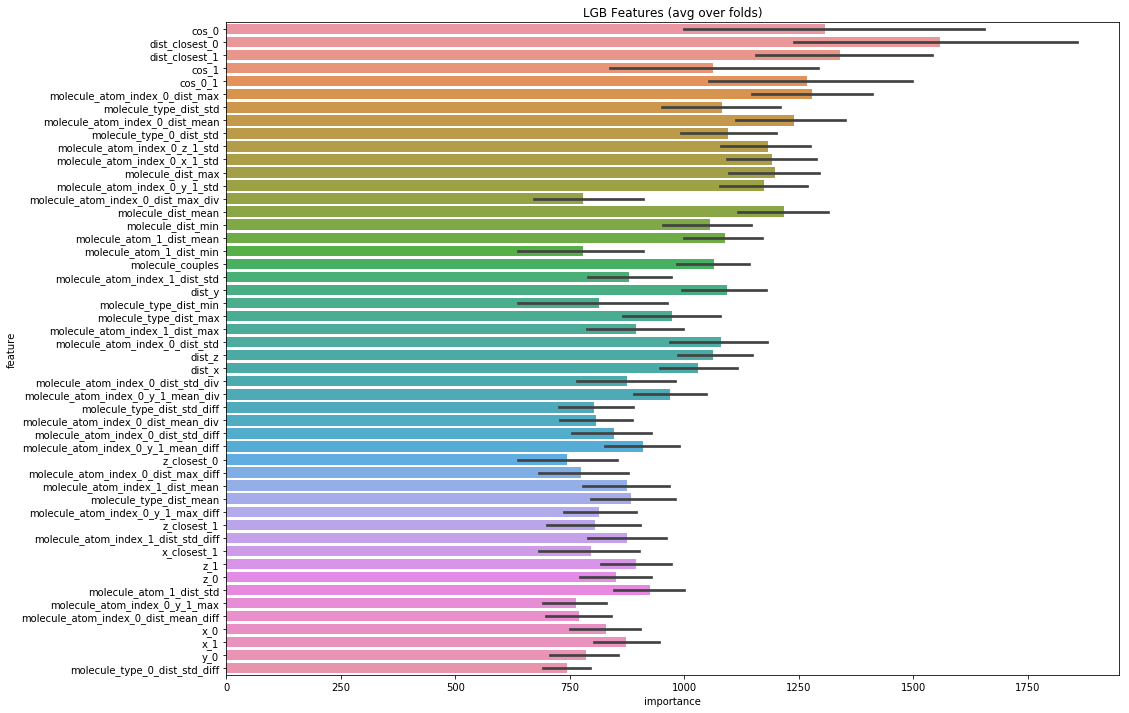

In [28]:
# top 50 features
cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
    by="importance", ascending=False)[:50].index

best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

plt.figure(figsize=(16, 12));
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
plt.title('LGB Features (avg over folds)');

# Save

**fc_feature**

test

In [66]:
# path_submittion = '../output/' + 'nb{}_submission_lgb_{}.csv'.format(nb, metric)
# path_submittion = 'nb{}_submission_lgb_{}.csv'.format(nb, metric)
path_fc = '../input/champs-scalar-coupling/nb{}_fc_test_feature.csv'.format(nb) 
print(f'save pash: {path_fc}')

save pash: ../input/champs-scalar-coupling/nb29_fc_test_feature.csv


In [67]:
# submittion = pd.read_csv('../input/champs-scalar-coupling/sample_submission.csv')
# submittion = pd.read_csv('./input/champs-scalar-coupling/sample_submission.csv')[::100]
# submittion['scalar_coupling_constant'] = prediction
# submittion.to_csv(reduce_mem_usage(pd.DataFrame({'fc': prediction})), index=False)
reduce_mem_usage(pd.DataFrame({'fc': prediction})).to_csv(path_fc, index=False)

Mem. usage decreased to 19.12 Mb (0.0% reduction)


train

In [77]:
path_fc = '../input/champs-scalar-coupling/nb{}_fc_train_feature.csv'.format(nb) 
print(f'save pash: {path_fc}')

save pash: ../input/champs-scalar-coupling/nb29_fc_train_feature.csv


In [78]:
pd.DataFrame(X_short['oof']).to_csv(path_fc, index=False)

# analysis

In [39]:
print(len(y_fc), len(X_short['oof']))

4658147 4658147


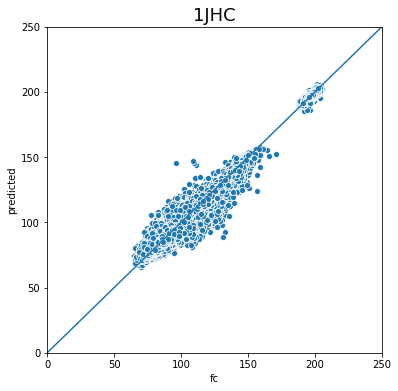

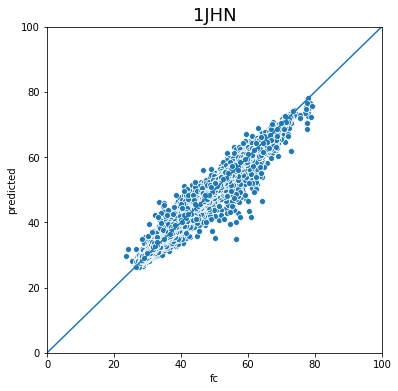

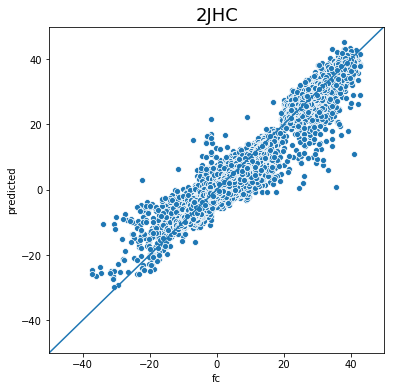

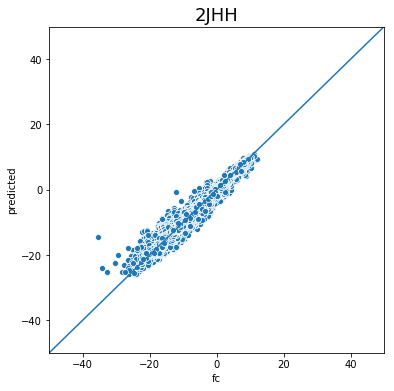

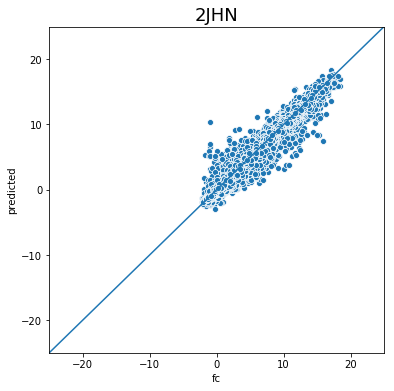

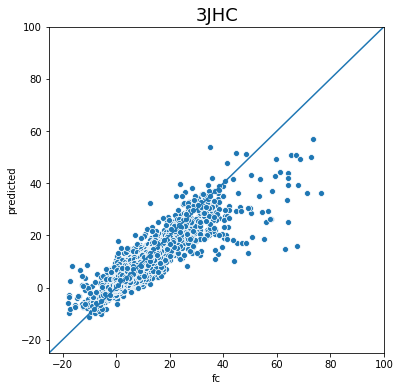

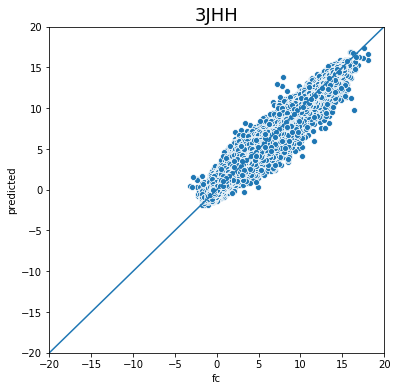

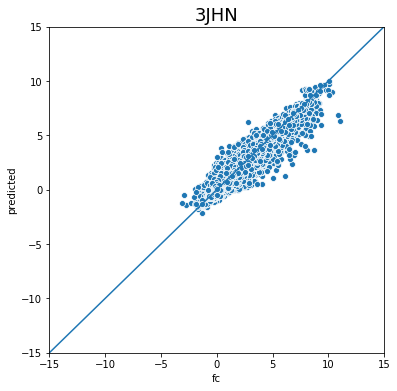

In [34]:
plot_data = pd.DataFrame(y_fc, columns=['fc'])
plot_data.index.name = 'id'
plot_data['yhat'] = X_short['oof']
plot_data['type'] = lbl.inverse_transform(X['type'])

def plot_oof_preds(ctype, llim, ulim):
        plt.figure(figsize=(6,6))
        sns.scatterplot(x='fc',y='yhat',
                        data=plot_data.loc[plot_data['type']==ctype,
                        ['fc', 'yhat']]);
        plt.xlim((llim, ulim))
        plt.ylim((llim, ulim))
        plt.plot([llim, ulim], [llim, ulim])
        plt.xlabel('fc')
        plt.ylabel('predicted')
        plt.title(f'{ctype}', fontsize=18)
        plt.show()


plot_oof_preds('1JHC', 0, 250)
plot_oof_preds('1JHN', 0, 100)
plot_oof_preds('2JHC', -50, 50)
plot_oof_preds('2JHH', -50, 50)
plot_oof_preds('2JHN', -25, 25)
plot_oof_preds('3JHC', -25, 100)
plot_oof_preds('3JHH', -20, 20)
plot_oof_preds('3JHN', -15, 15)